In [1]:
from tqdm import tqdm
import math
import numpy as np
import torch
from torch import utils
from torch import nn
from torch import distributions
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToPILImage

import lightning as pl

import matplotlib.pyplot as plt

In [2]:
data_dir = '/Users/armandli/data/'

In [3]:
checkpoint_dir = '/Users/armandli/journal/models/'

In [4]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_built()
if use_cuda:
    device = torch.device('cuda')
elif use_mps:
    device = torch.device('cpu')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')

In [5]:
default_batch_size = 256
loader_args = {'batch_size' : default_batch_size, 'shuffle' : True}
score_args = {'batch_size' : default_batch_size, 'shuffle' : False}
if use_cuda:
    loader_args.update({'pin_memory' : True})
    score_args.update({'pin_memory' : True})

Model

In [6]:
class MaskedConv2d(nn.Module):
    def __init__(self, in_c, out_c, mask, **kwargs):
        super(MaskedConv2d, self).__init__()
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if 'dilation' not in kwargs else kwargs['dilation']
        padding = tuple(dilation*(kernel_size[i]-1)//2 for i in range(2))
        self.conv = nn.Conv2d(in_c, out_c, kernel_size, padding=padding, **kwargs)
        # we don't take gradient on mask, but we also need to save it
        self.register_buffer('mask', mask[None, None]) #mask[None, None] expand mask shape by 2 dimensions
    
    def forward(self, x):
        self.conv.weight.data *= self.mask
        return self.conv(x)

In [7]:
class VSMConv2d(MaskedConv2d):
    def __init__(self, in_c, out_c, kernel_size=3, mask_center=False, **kwargs):
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0.
        if mask_center:
            mask[kernel_size//2,:] = 0.
        super(VSMConv2d, self).__init__(in_c, out_c, mask, **kwargs)

In [8]:
class HSMConv2d(MaskedConv2d):
    def __init__(self, in_c, out_c, kernel_size=3, mask_center=False, **kwargs):
        mask = torch.ones(kernel_size, kernel_size)
        mask[:kernel_size//2,:] = 0.
        mask[kernel_size//2+1:,:] = 0.
        mask[:,kernel_size//2+1:] = 0.
        if mask_center:
            mask[kernel_size//2,kernel_size//2] = 0.
        super(HSMConv2d, self).__init__(in_c, out_c, mask, **kwargs)

In [9]:
class GatedMaskConv2d(nn.Module):
    def __init__(self, in_c, **kwargs):
        super(GatedMaskConv2d, self).__init__()
        self.conv_v = VSMConv2d(in_c, in_c*2, **kwargs)
        self.conv_h = HSMConv2d(in_c, in_c*2, **kwargs)
        self.conv_v2h = nn.Conv2d(in_c*2, in_c*2, kernel_size=1, padding=0)
        self.conv_h_1x1 = nn.Conv2d(in_c, in_c, kernel_size=1, padding=0)

    def forward(self, v_stack, h_stack):
        v_stack_feat = self.conv_v(v_stack)
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)

        h_stack_feat = self.conv_h(h_stack)
        h_stack_feat = h_stack_feat + self.conv_v2h(v_stack_feat)
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_out = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_h_1x1(h_stack_out)
        h_stack_out = h_stack_out + h_stack

        return (v_stack_out, h_stack_out)

In [21]:
class PixelCNN(nn.Module):
    def __init__(self, in_c, hidden_c):
        super(PixelCNN, self).__init__()
        self.conv_vstack = HSMConv2d(in_c, hidden_c, mask_center=True)
        self.conv_hstack = HSMConv2d(in_c, hidden_c, mask_center=True)
        self.conv_layers = nn.ModuleList([
            GatedMaskConv2d(hidden_c, mask_center=True),
            GatedMaskConv2d(hidden_c, mask_center=False),
            GatedMaskConv2d(hidden_c, mask_center=False, dilation=2),
            GatedMaskConv2d(hidden_c, mask_center=False),
            GatedMaskConv2d(hidden_c, mask_center=False, dilation=4),
            GatedMaskConv2d(hidden_c, mask_center=False),
            GatedMaskConv2d(hidden_c, mask_center=False, dilation=2),
            GatedMaskConv2d(hidden_c, mask_center=False),
        ])
        self.conv_out = nn.Conv2d(hidden_c, in_c*256, kernel_size=1, padding=0)

    def forward(self, x):
        # scale input x to -1 to 1
        x = (x.float() / 255.0) * 2 - 1
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        out = self.conv_out(F.elu(h_stack))
        # reshape into (N, Class, Channel, Height, Width)
        out = out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out

    def sample(self, img_shape, device):
        img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        for h in range(img_shape[2]):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    pred = self.forward(img[:,:,:h+1,:])
                    probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                    img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img

testing receptive field

In [12]:
def show_center_recep_field(img, out):
    # Determine gradients
    loss = out[0,:,img.shape[2]//2,img.shape[3]//2].sum() # L1 loss for simplicity
    loss.backward(retain_graph=True) # Retain graph as we want to stack multiple layers and show the receptive field of all of them
    img_grads = img.grad.abs()
    img.grad.fill_(0) # Reset grads

    # Plot receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1,2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img>0)
    # Mark the center pixel in red if it doesn't have any gradients (should be the case for standard autoregressive models)
    show_center = (img[img.shape[0]//2,img.shape[1]//2] == 0)
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0])
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

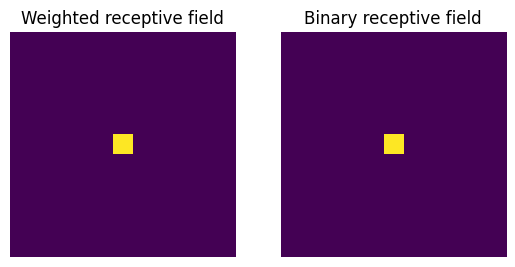

In [13]:
inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()
show_center_recep_field(inp_img, inp_img)

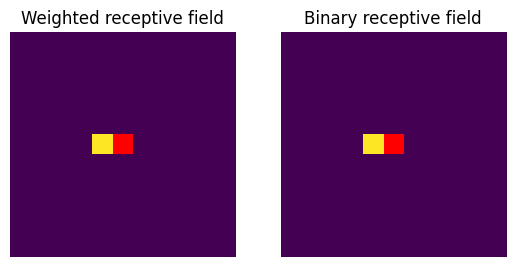

In [14]:
horiz_conv = HSMConv2d(1, 1, kernel_size=3, mask_center=True)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
horiz_img = horiz_conv(inp_img)
show_center_recep_field(inp_img, horiz_img)

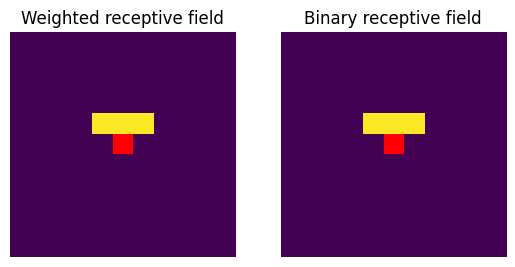

In [15]:
vert_conv = VSMConv2d(1, 1, kernel_size=3, mask_center=True)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)
vert_img = vert_conv(inp_img)
show_center_recep_field(inp_img, vert_img)

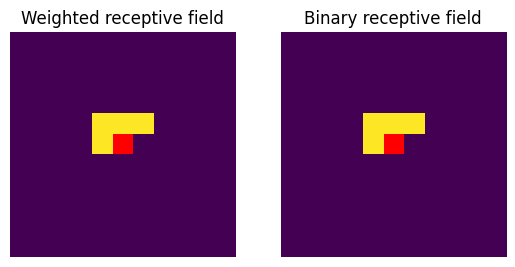

In [16]:
horiz_img = horiz_img + vert_img
show_center_recep_field(inp_img, horiz_img)

Layer 2


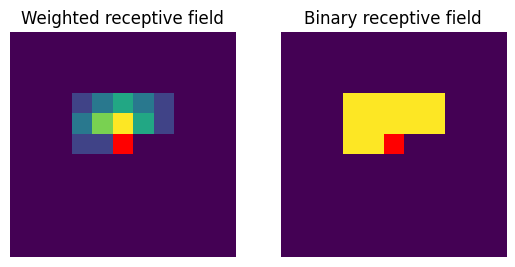

Layer 3


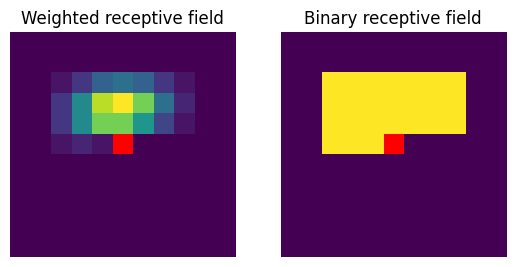

Layer 4


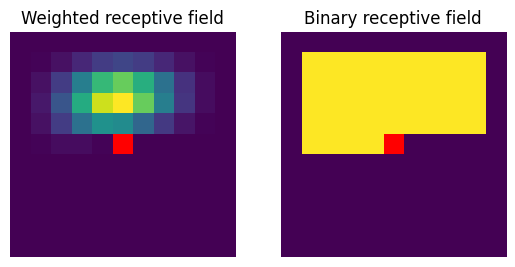

Layer 5


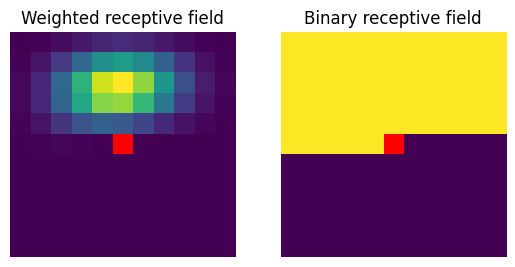

In [17]:
# Initialize convolutions with equal weight to all input pixels
horiz_conv = HSMConv2d(1, 1, kernel_size=3, mask_center=False)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
vert_conv = VSMConv2d(1, 1, kernel_size=3,mask_center=False)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)

# We reuse our convolutions for the 4 layers here. Note that in a standard network,
# we don't do that, and instead learn 4 separate convolution. As this cell is only for
# visualization purposes, we reuse the convolutions for all layers.
for l_idx in range(4):
    vert_img = vert_conv(vert_img)
    horiz_img = horiz_conv(horiz_img) + vert_img
    print(f"Layer {l_idx+2}")
    show_center_recep_field(inp_img, horiz_img)

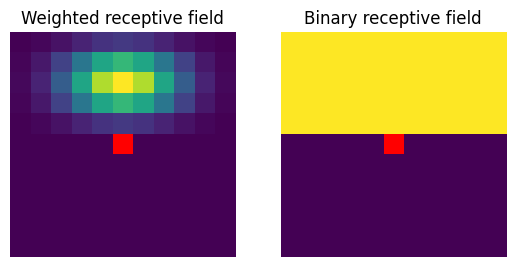

In [18]:
show_center_recep_field(inp_img, vert_img)

In [19]:
del inp_img, horiz_conv, vert_conv

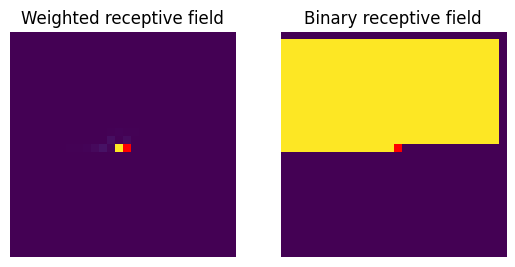

In [124]:
test_model = PixelCNN(1, 64)
inp = torch.zeros(1,1,28,28)
inp.requires_grad_()
out = test_model(inp)
show_center_recep_field(inp, out.squeeze(dim=2))
del inp, out, test_model

data

In [11]:
# Convert images from 0-1 to 0-255 (integers). We use the long datatype as we will use the images as labels as well
def discretize(sample):
    return (sample * 255).to(torch.long)

In [12]:
transform = transforms.Compose([transforms.ToTensor(), discretize])

In [13]:
trainset = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
evalset  = datasets.MNIST(root=data_dir, train=False, transform=transform, download=True)

In [ ]:
trainset = datasets.CIFAR10(root=data_dir, train=True, transform=transform, download=True)
evalset = datasets.CIFAR10(root=data_dir, train=True, transform=transform, download=True)

In [ ]:
trainset = datasets.CIFAR100(root=data_dir, train=True, transform=transform, download=True)
evalset = datasets.CIFAR100(root=data_dir, train=False, transform=transform, download=True)

In [14]:
len(trainset), len(evalset)

(60000, 10000)

In [15]:
train_loader = utils.data.DataLoader(dataset=trainset, **loader_args)
eval_loader = utils.data.DataLoader(dataset=evalset, **score_args)

training

In [15]:
class PixelCNN(pl.LightningModule):

    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.save_hyperparameters()

        # Initial convolutions skipping the center pixel
        self.conv_vstack = VSMConv2d(c_in, c_hidden, mask_center=True)
        self.conv_hstack = HSMConv2d(c_in, c_hidden, mask_center=True)
        # Convolution block of PixelCNN. We use dilation instead of downscaling
        self.conv_layers = nn.ModuleList([
            GatedMaskConv2d(c_hidden),
            GatedMaskConv2d(c_hidden, dilation=2),
            GatedMaskConv2d(c_hidden),
            GatedMaskConv2d(c_hidden, dilation=4),
            GatedMaskConv2d(c_hidden),
            GatedMaskConv2d(c_hidden, dilation=2),
            GatedMaskConv2d(c_hidden)
        ])
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)

        self.example_input_array = trainset[0][0][None]

    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        x = (x.float() / 255.0) * 2 - 1

        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))

        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        out = out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out

    def calc_likelihood(self, x):
        # Forward pass with bpd likelihood calculation
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='none')
        bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
        return bpd.mean()

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # Skip if not to be filled (-1)
                    if (img[:,c,h,w] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    pred = self.forward(img[:,:,:h+1,:])
                    probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                    img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('test_bpd', loss)

In [17]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=checkpoint_dir + 'PixelCNN',
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=150)
    model = PixelCNN(**kwargs)
    trainer.fit(model, train_loader, eval_loader)
    model = model.to(device)
    # Test best model on validation and test set
    val_result = trainer.test(model, eval_loader, verbose=False)
    result = {"eval": val_result}
    return model, result

In [18]:
model, result = train_model(c_in=1, c_hidden=64)
test_res = result["eval"][0]
print("Test bits per dimension: %4.3fbpd" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_bpd"]))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/armandli/journal/env/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/armandli/journal/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name        | Type       | Params | In sizes        | Out sizes       
----------------------------------------------------

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/armandli/journal/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/Users/armandli/journal/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 2:  47%|████▋     | 110/235 [13:46<15:38,  0.13it/s, v_num=1]

sampling

In [16]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

In [17]:
model = PixelCNN(1, 64)

  0%|          | 0/28 [00:00<?, ?it/s]

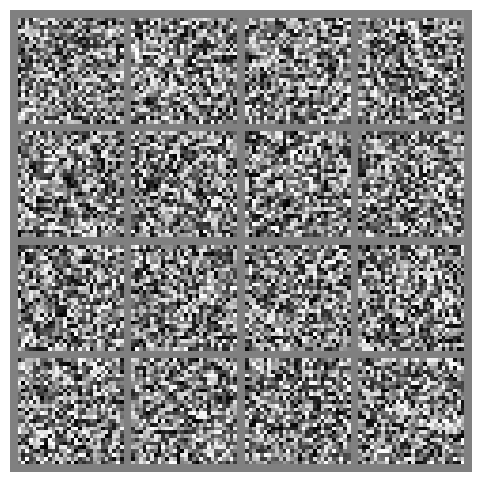

In [18]:
samples = model.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

test

In [26]:
model = PixelCNN(1, 64)

In [27]:
input = trainset[0][0].unsqueeze(0)

In [36]:
input.shape

torch.Size([1, 1, 28, 28])

In [28]:
output = model(input)

gothere10 torch.Size([1, 256, 28, 28])


In [19]:
output

tensor([[[[[-0.2760, -0.4293, -0.4306,  ..., -0.4320, -0.4322, -0.4324],
           [-0.2763, -0.4205, -0.4220,  ..., -0.4233, -0.4235, -0.4192],
           [-0.2754, -0.4193, -0.4207,  ..., -0.4226, -0.4231, -0.4193],
           ...,
           [-0.2755, -0.4193, -0.4205,  ..., -0.4226, -0.4228, -0.4192],
           [-0.2755, -0.4193, -0.4205,  ..., -0.4226, -0.4228, -0.4192],
           [-0.2755, -0.4193, -0.4204,  ..., -0.4226, -0.4228, -0.4192]]],


         [[[ 0.2234,  0.1589,  0.1520,  ...,  0.1593,  0.1599,  0.1595],
           [ 0.2258,  0.1584,  0.1560,  ...,  0.1621,  0.1620,  0.1631],
           [ 0.2253,  0.1586,  0.1565,  ...,  0.1640,  0.1647,  0.1658],
           ...,
           [ 0.2255,  0.1589,  0.1569,  ...,  0.1644,  0.1649,  0.1659],
           [ 0.2255,  0.1588,  0.1569,  ...,  0.1644,  0.1649,  0.1659],
           [ 0.2255,  0.1588,  0.1567,  ...,  0.1644,  0.1649,  0.1659]]],


         [[[-0.1364, -0.0224, -0.0271,  ..., -0.0229, -0.0229, -0.0236],
           

In [29]:
output.shape

torch.Size([1, 256, 1, 28, 28])

In [32]:
nll = F.cross_entropy(output, input, reduction='none')
nll.shape

torch.Size([1, 1, 28, 28])

In [37]:
nll

tensor([[[[5.3618, 5.3068, 5.3144, 5.2944, 5.2867, 5.2922, 5.2917, 5.2914,
           5.2915, 5.2914, 5.2914, 5.2914, 5.2914, 5.2914, 5.2914, 5.2914,
           5.2914, 5.2914, 5.2914, 5.2914, 5.2914, 5.2914, 5.2914, 5.2915,
           5.2914, 5.2914, 5.2917, 5.2921],
          [5.3523, 5.2972, 5.3034, 5.2833, 5.2755, 5.2809, 5.2804, 5.2802,
           5.2802, 5.2802, 5.2802, 5.2802, 5.2802, 5.2802, 5.2802, 5.2802,
           5.2802, 5.2802, 5.2802, 5.2802, 5.2802, 5.2802, 5.2802, 5.2802,
           5.2801, 5.2803, 5.2802, 5.2860],
          [5.3518, 5.2972, 5.3027, 5.2831, 5.2753, 5.2806, 5.2802, 5.2800,
           5.2800, 5.2800, 5.2800, 5.2800, 5.2800, 5.2800, 5.2800, 5.2800,
           5.2800, 5.2800, 5.2800, 5.2800, 5.2800, 5.2800, 5.2800, 5.2800,
           5.2799, 5.2802, 5.2803, 5.2872],
          [5.3517, 5.2971, 5.3023, 5.2826, 5.2747, 5.2800, 5.2796, 5.2794,
           5.2794, 5.2794, 5.2794, 5.2794, 5.2794, 5.2794, 5.2794, 5.2794,
           5.2794, 5.2794, 5.2794, 5.2794, 

In [33]:
bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
bpd

tensor([7.7039], grad_fn=<MulBackward0>)

In [34]:
bpd.mean()

tensor(7.7039, grad_fn=<MeanBackward0>)

In [35]:
np.log2(np.exp(1))

1.4426950408889634